In [1]:
import os
import re
import operator
import unidecode
from bs4 import BeautifulSoup
import json, csv

import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
titles_dataset = []
n_authors_per_paper = dict()
authors_dataset = dict()
institution_dataset = dict()
one_author = []

datasetFolderName = "data/" 
fileName = datasetFolderName + "raw_data_090619.txt"

In [3]:
def remove_empty_lines(fileName):
    if not os.path.isfile(fileName):
        print("{} does not exist ".format(fileName))
        return
    with open(fileName) as filehandle:
        lines = filehandle.readlines()

    with open(fileName, 'w') as filehandle:
        lines = filter(lambda x: x.strip(), lines)
        filehandle.writelines(lines)   

remove_empty_lines(fileName)

In [4]:
def fill_datasets(fileName):
  with open(fileName, 'r') as file:
    for paper in file:
      soup = BeautifulSoup(paper, features="html.parser")
      titles_dataset.append( soup.b.get_text() )
      list_authors = soup.i.get_text().split('· ')
      number_authors = len(list_authors)
      
      if number_authors == 1:
        one_author.append(list_authors)

      if number_authors not in n_authors_per_paper:
          n_authors_per_paper[number_authors] = 1
      else:
          n_authors_per_paper[number_authors] += 1

      tmp_institution_set = set()
      for i in range( number_authors ):
          author_afiliation = list_authors[i].split(" (")
          tmp_author = author_afiliation[0][0:]
          tmp_author = unidecode.unidecode(tmp_author)

          if tmp_author not in authors_dataset:
              authors_dataset[tmp_author] = 1
          else:
              authors_dataset[tmp_author] += 1

          tmp_institution = author_afiliation[1].rstrip(") ").rstrip(")").replace('"', '').replace(';', '')
          # some authors have not updated their institution
          # if tmp_institution == '':
          # 	print(list_authors)
          # clearing some blank spaces at the end of each instituion, removing
          # accents and making strings case insensitive
          tmp_institution = tmp_institution.rstrip()
          tmp_institution = tmp_institution.lstrip()
          tmp_institution = unidecode.unidecode(tmp_institution).lower()
          tmp_institution_set.add(tmp_institution)
          # if  tmp_institution not in institution_dataset:
          # 	institution_dataset[tmp_institution] = 1
          # else:
          # 	institution_dataset[tmp_institution] += 1
      for i in tmp_institution_set:

          if  i not in institution_dataset:
              institution_dataset[i] = 1
          else:
              institution_dataset[i] += 1

In [5]:
def save_datasets_to_file():
	tmp = sorted(institution_dataset.items(), key=operator.itemgetter(1),reverse=True)
	with open(datasetFolderName+'institution_dataset.csv', 'w') as f:
		for key in tmp:
			f.write("%s;%s\n"%(key[0], key[1]))
	f.close()
	json1 = json.dumps(sorted(n_authors_per_paper.items(), key=operator.itemgetter(0)))
	json2 = json.dumps(sorted(authors_dataset.items(), key=operator.itemgetter(1),reverse=True))
	json3 = json.dumps(sorted(institution_dataset.items(), key=operator.itemgetter(1),reverse=True))
	f1 = open(datasetFolderName + "n_authors_per_paper.json","w")
	f2 = open(datasetFolderName + "authors_dataset.json","w")
	f3 = open(datasetFolderName + "institution_dataset.json","w")
	f1.write(json1)
	f2.write(json2)
	f3.write(json3)
	f1.close()
	f2.close()
	f3.close()

In [6]:
fill_datasets(fileName)

In [7]:
save_datasets_to_file()

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

from IPython.display import Image

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

In [9]:
n_authors_fileDir = "data/n_authors_per_paper.json"
institution_fileDir = "data/institution_dataset.json"
authors_fileDir = "data/authors_dataset.json"


In [10]:
with open(n_authors_fileDir) as handle:
    n_authors_per_paper = json.loads(handle.read())

trace0 = go.Bar(
            x = [x[0] for x in n_authors_per_paper],
            y = [y[1] for y in n_authors_per_paper],
            text=[y[1] for y in n_authors_per_paper],
            textposition = 'auto',
            name='Number of authors per paper',
            marker=dict(
                color='rgb(49,130,189)'
            )
    )
data = [trace0]

layout = go.Layout(
    title=go.layout.Title(
        text='Number of Authors per Paper',
#         xref='paper'
    ),
    xaxis=go.layout.XAxis(
        tickangle=0,
        title=go.layout.xaxis.Title(
            text='Number of authors',
            font=dict(
#                 family='Courier New, monospace',
                size=12,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Papers with N Authors',
            font=dict(
#                 family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

init_notebook_mode(connected=True)
fig = go.Figure(data=data, layout=layout)
static_image_bytes = pio.to_image(fig, format='png')
Image(static_image_bytes)

pio.write_image(fig, file='imgs/authors_per_paper.png', format='png')

In [11]:
with open(authors_fileDir) as handle:
    authors_dataset = json.loads(handle.read())

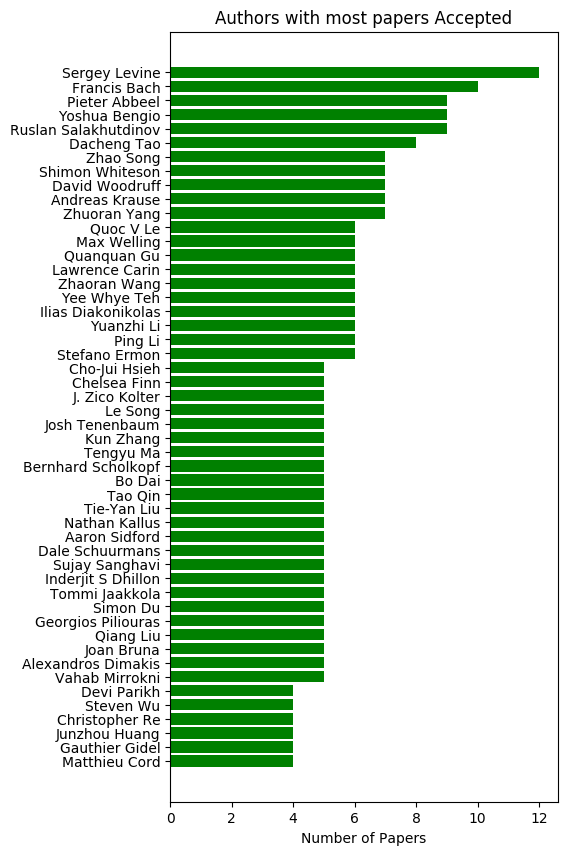

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()

fig, ax = plt.subplots(figsize=(5, 10))

nTop = 50

nPapers = [x[1] for x in authors_dataset[:nTop]]
people = [x[0] for x in authors_dataset[:nTop]]

ax.barh(people, nPapers, align='center',
        color='green', ecolor='black')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Papers')
ax.set_title('Authors with most accepted papers')

# plt.show()
# plt.savefig('authors_rank_by_accepted_papers.png', bbox_inches='tight')
plt.savefig('authors_rank_by_accepted_papers.png', bbox_inches='tight')

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import csv

fileDir = "data/handcounted_inst.csv"

institutions = []

with open(fileDir, mode='r') as csv_file:
    for line in csv_file:
        institutions.append( line.rstrip().split(";") )
csv_file.close()

institutions.sort(key=lambda x: int(x[1]), reverse=True)

print(institutions[:25])

[['Google, Google Brain, Deepmind', '223'], ['Stanford University', '121'], ['Massachusetts Institute of Technology', '118'], ['University of California, Berkeley', '117'], ['Microsoft', '104'], ['Carnegie Mellon University', '103'], ['Facebook AI Research', '59'], ['IBM research', '58'], ['Princeton University', '55'], ['INRIA', '55'], ['Columbia University', '51'], ['Georgia Institute of Technology', '50'], ['University of Washington', '46'], ['Tsinghua University', '45'], ['University of Oxford', '45'], ['MILA', '45'], ['University of Texas at Austin', '44'], ['University of California, Los Angeles', '43'], ['University of Toronto', '43'], ['Cornell University', '42'], ['University of Southern California', '38'], ['New York University', '36'], ['ETH Zurich', '35'], ['University of Illinois at Urbana-Champaign', '35'], ['EPFL', '34']]


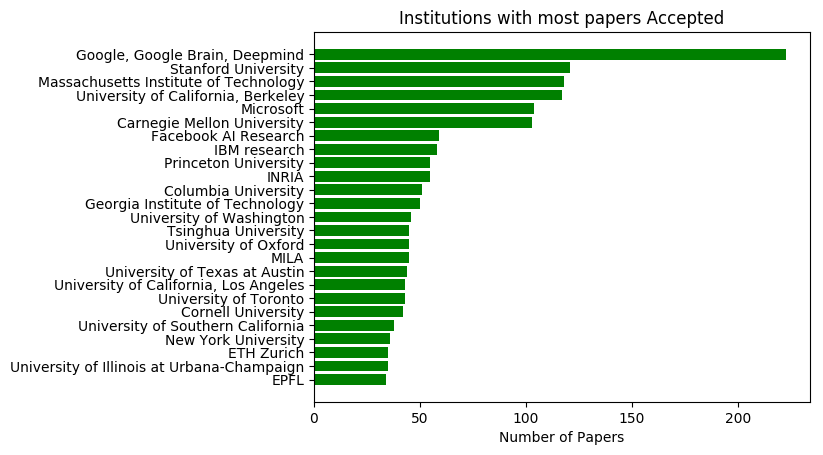

In [14]:
plt.rcdefaults()
fig, ax = plt.subplots()
nTop = 25

nPapers = [int(x[1]) for x in institutions[:nTop]]
institutionNames = [x[0] for x in institutions[:nTop]]

ax.barh(institutionNames, nPapers, align='center',
        color='green', ecolor='black')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Papers')
ax.set_title('Institutions with most accepted papers')

# plt.show()
plt.savefig('institutions_ranked_by_accepted_papers.png', bbox_inches='tight')

In [15]:
titles_dataset[:5]

['Multimodal Model-Agnostic Meta-Learning via Task-Aware Modulation',
 'ViLBERT: Pretraining Task-Agnostic Visiolinguistic Representations for Vision-and-Language Tasks',
 'Stochastic Shared Embeddings: Data-driven Regularization of Embedding Layers',
 'Unsupervised Scale-consistent Depth and Ego-motion Learning from Monocular Video',
 'Zero-shot Learning via Simultaneous Generating and Learning']

In [16]:
word_list = []
stopwords_deep_learning = ["a", "using", "on", "via"]

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from collections import Counter
  
stop_words = set(stopwords.words('english')) 

for title in titles_dataset:
  words = title.split()
  for word in words:
    if word.lower() not in stopwords.words('english') and word.lower() not in stopwords_deep_learning:
      word_list.append(word.lower())
word_list


keyword_counter = Counter(word_list)

num_words = 30
keywords_counter_vis = keyword_counter.most_common(num_words)

In [17]:
keywords_counter_vis

[('learning', 342),
 ('neural', 153),
 ('networks', 145),
 ('deep', 114),
 ('optimization', 70),
 ('reinforcement', 60),
 ('models', 56),
 ('graph', 56),
 ('adversarial', 54),
 ('efficient', 47),
 ('stochastic', 46),
 ('optimal', 44),
 ('generative', 43),
 ('data', 42),
 ('model', 42),
 ('gradient', 40),
 ('network', 38),
 ('adaptive', 38),
 ('training', 37),
 ('bayesian', 37),
 ('robust', 35),
 ('estimation', 34),
 ('variational', 34),
 ('online', 34),
 ('linear', 33),
 ('image', 31),
 ('analysis', 30),
 ('inference', 30),
 ('time', 29),
 ('sparse', 28)]

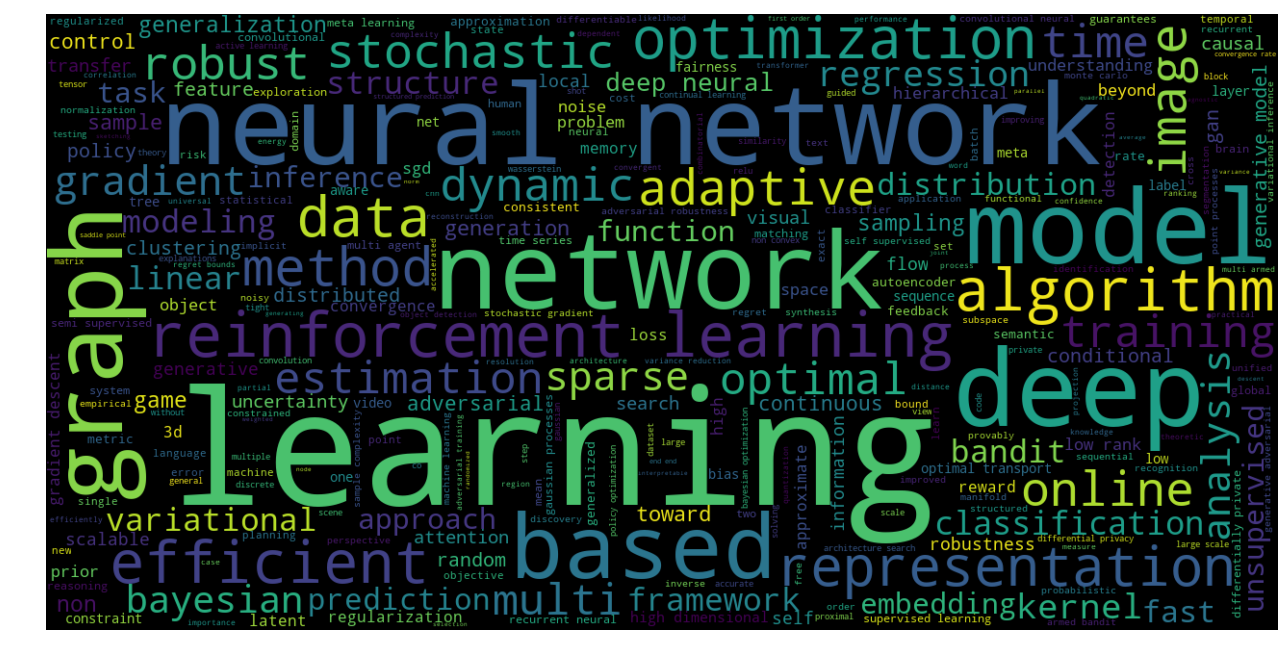

In [21]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=166, max_words=300, 
                      width=1280, height=640,
                      repeat=False,
                      background_color="black").generate(' '.join(word_list))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.show()
plt.savefig('titles_wordcloud.png', bbox_inches='tight')

In [19]:
n_authors_per_paper

[[1, 40],
 [2, 273],
 [3, 367],
 [4, 315],
 [5, 227],
 [6, 101],
 [7, 60],
 [8, 17],
 [9, 14],
 [10, 6],
 [11, 4],
 [13, 1],
 [14, 1],
 [15, 1],
 [17, 1],
 [21, 1]]

In [20]:
one_author

[['Justin Domke (University of Massachusetts, Amherst)'],
 ['Max Vladymyrov (Google)'],
 ['Wang Chi Cheung (Department of Industrial Systems Engineering and Management, National University of Singapore)'],
 ['Hedi Hadiji (Laboratoire de Mathematiques d’Orsay, Univ. Paris-Sud,)'],
 ['Mete Ozay (Independent Researcher (N/A))'],
 ['Zhize Li (Tsinghua University)'],
 ['Rui Li (Rochester Institute of Technology)'],
 ['Aaron Defazio (Facebook AI Research)'],
 ['Alan Kuhnle (Florida State University)'],
 ['Matthew Holland (Osaka University)'],
 ['Sivan Sabato (Ben-Gurion University of the Negev)'],
 ['Eric Jonas (University of Chicago)'],
 ['Harald Steck (Netflix)'],
 ['Edward Raff (Booz Allen Hamilton)'],
 ['Vrettos Moulos (UC Berkeley)'],
 ['Philippe Casgrain (University of Toronto)'],
 ['Weiwei Liu (Wuhan University)'],
 ['Akinori Tanaka (RIKEN)'],
 ['Laurence Aitchison (University of Cambridge)'],
 ['Ananda Theertha Suresh (Google)'],
 ['Frederic Koehler (MIT)'],
 ['Hao Yu (Alibaba Group 